# An Attempt to Predict Future Asset Price Change
Problem Definition:

Given a time series of past N days of an asset's trading data (including price, volume, etc.) predict the average price change in next M days.

## Download Data

In [1]:
!pip install wget
import wget

func = 'TIME_SERIES_DAILY'
symbol = 'QQQ'
apikey = 'IKWMTUXX8D661SPO'
datatype = 'csv'
outputsize = 'full'
requesturl = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&datatype={}&outputsize={}'.format(func,symbol,apikey,datatype,outputsize)
# requesturl = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey={}&datatype=csv'.format(apikey)
filename = wget.download(requesturl)

## Load Data

In [2]:
import pandas as pd
import numpy as np

# filename = 'daily_QQQ.csv'
df_o = pd.read_csv(filename)
df = df_o.sort_values(['timestamp'])
df = df.reset_index(drop=True)
df

,timestamp,open,high,low,close,volume
0,2000-02-03,188.60,193.3000,184.6000,193.00,15289900
1,2000-02-04,194.00,196.5000,192.4000,194.30,13320000
2,2000-02-07,194.50,197.3000,192.5000,197.00,8880500
3,2000-02-08,198.80,205.8000,198.8000,205.30,10999700
4,2000-02-09,204.10,204.4000,197.5000,198.00,13629100
5,2000-02-10,199.60,204.5000,197.1000,204.50,13170800
6,2000-02-11,204.10,204.1000,196.0000,199.80,12438000
7,2000-02-14,200.00,200.0000,195.5000,199.50,11407300
8,2000-02-15,197.90,201.3000,191.8000,200.90,15286400
9,2000-02-16,199.80,203.4000,198.6000,200.00,12655300


## Compute Daily Fractional Changes


In [3]:
df_processed = pd.DataFrame()
df_processed[['daily_price_change', 'daily_volume_change']] = df[['close', 'volume']].pct_change()

pred_days = 5
df_processed['average_price_change_in_next_{}_days'.format(pred_days)] = df['close'].rolling(window=pred_days).mean().shift(-pred_days)/df['close']-1
df_processed = df_processed.dropna()
df_processed

,daily_price_change,daily_volume_change,average_price_change_in_next_5_days
1,0.006736,-0.128837,0.034071
2,0.013896,-0.333296,0.022437
3,0.042132,0.238635,-0.023186
4,-0.035558,0.239043,0.014848
5,0.032828,-0.033627,-0.017604
6,-0.022983,-0.055638,0.002603
7,-0.001502,-0.082867,0.002105
8,0.007018,0.340054,0.002688
9,-0.004480,-0.172120,0.020200
10,0.021500,0.188443,0.002447


## Prepare Features & Labels
* Input feature (x): N days history of features up till today (dimension: ?, N, 2)
* Output label (y): The next day close price change from today (dimension: ?, 1)

In [4]:
history_days = 200

features = df_processed.iloc[:, :-1].values 
x = np.array([features[i:i+history_days] for i in range(0, len(features)-history_days+1)])
y = df_processed.iloc[:,-1].values[history_days-1:].reshape(-1,1)

# print(x)
# print(y)
print(x.shape, y.shape)

(4827, 200, 2) (4827, 1)


## Check Label Distribution

In [5]:
import matplotlib.pyplot as plt

_ = plt.hist(y, bins='auto')

## Prepare Training and Testing data
Because stock has bear and bull markets, we should sample randomly from the full data to get test samples. Otherwise, the test result may not be representative enough.

In [6]:
import numpy as np

totalsamples = x.shape[0]
testsamples = 300
idxs = np.arange(totalsamples)
np.random.shuffle(idxs)

x_train = x[idxs][:-testsamples]
y_train = y[idxs][:-testsamples]
x_test = x[idxs][-testsamples:]
y_test = y[idxs][-testsamples:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4527, 200, 2) (4527, 1)
(300, 200, 2) (300, 1)


## NetGenerator

In [7]:
import tensorflow as tf
from keras import optimizers

class NetGenerator():
  def __init__(self, input_shape, out_size):
    self.input_shape = input_shape
    self.out_size = out_size

  def next(self):

    modelnames =[
      'lstm-30day',
    ]
     
    for idx, name in enumerate(modelnames):
      
      model = None
      inputs = keras.Input(shape=self.input_shape)
    #   x = keras.layers.Conv1D(filters=20, kernel_size=3, strides=1,padding='same')(inputs)
    #   x = keras.layers.BatchNormalization()(x)
    #   x = keras.layers.Activation('relu')(x)

      x = keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(inputs)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(x)
      x = keras.layers.BatchNormalization()(x)

      x = keras.layers.Dense(self.out_size)(x)
      x = keras.layers.Activation('tanh')(x)
      model = keras.Model(inputs=inputs, outputs=x)
      model.compile(
          loss='mean_squared_error',
          optimizer=optimizers.Adam(lr=0.001)
      )

      yield (name, model)


Using TensorFlow backend.


## Training

In [8]:
# !pip install tensorboardcolab
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

# tbc=TensorBoardColab(port=6007, graph_path='.', startup_waiting_time=8)

In [10]:
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K 
import tensorflow as tf

print (keras.__version__)
print (tf.__version__)

net_gen = NetGenerator(
    input_shape=x_train[0].shape, 
    out_size=y_train[0].shape[0], 
)

# very important or error
K.clear_session()
net_generator = net_gen.next()
modelconfig=next(net_generator,None)
  
while modelconfig!=None:

    modelname,model = modelconfig

    print(modelname)
    model.summary()

    cb_tensorboard = TensorBoard(
        log_dir='./log/'+modelname,
        histogram_freq=100,  
        write_graph=True, 
        write_images=False,
        write_grads=False,
#         update_freq ='epoch'
    )

    cb_checkpoint = ModelCheckpoint(
        './log/'+modelname+'_weights.h5', 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto', 
        period=1
    )

    model.fit(
        x=x_train, 
        y=y_train, 
        batch_size=256, 
        epochs=200, 
        verbose=1, 
        callbacks=[cb_tensorboard, cb_checkpoint], 
        validation_split=0.1, 
        shuffle=True, 
        initial_epoch=0, 
        steps_per_epoch=None, 
        validation_steps=None, 
#         validation_freq=1
    )


#     model.fit_generator(
#       initial_epoch = 0,
#       generator=train_gen.next(), 
#       steps_per_epoch = train_gen.steps,
#       epochs = 100,
#       validation_data = next(valid_gen.next()), #in order to save histogram must not be generator, else can
#       validation_steps = valid_gen.steps,
# #       validation_freq = 1,
#       callbacks=[cb_tensorboard, cb_checkpoint]
#     )
    
    # very important or error
    K.clear_session()
    modelconfig=next(net_generator,None)

print('All done')

2.2.4
1.13.1
lstm-30day
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 2)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          67072     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 128)          512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)              

Epoch 63/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0015 - val_loss: 6.3841e-04
Epoch 64/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0014 - val_loss: 6.6876e-04
Epoch 65/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0016 - val_loss: 6.1855e-04
Epoch 66/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0016 - val_loss: 8.3429e-04
Epoch 67/200
4074/4074 [==============================] - 10s 3ms/step - loss: 0.0014 - val_loss: 7.2052e-04
Epoch 68/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0014 - val_loss: 7.6398e-04
Epoch 69/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0014 - val_loss: 6.2143e-04
Epoch 70/200
4074/4074 [==============================] - 10s 2ms/step - loss: 0.0012 - val_loss: 5.3035e-04
Epoch 71/200
4074/4074 [==============================] - 10s 3ms/step - loss: 0.0017 - val_loss: 7.0374e-04
Epoch 72/200
4074/4

4074/4074 [==============================] - 10s 2ms/step - loss: 8.3552e-04 - val_loss: 5.4209e-04
Epoch 137/200
4074/4074 [==============================] - 10s 2ms/step - loss: 7.6890e-04 - val_loss: 8.4146e-04
Epoch 138/200
4074/4074 [==============================] - 10s 2ms/step - loss: 7.9088e-04 - val_loss: 6.8394e-04
Epoch 139/200
4074/4074 [==============================] - 10s 2ms/step - loss: 7.9601e-04 - val_loss: 6.6003e-04
Epoch 140/200
4074/4074 [==============================] - 10s 2ms/step - loss: 8.4244e-04 - val_loss: 7.0255e-04
Epoch 141/200
4074/4074 [==============================] - 10s 2ms/step - loss: 8.8494e-04 - val_loss: 7.1260e-04
Epoch 142/200
4074/4074 [==============================] - 10s 2ms/step - loss: 7.6292e-04 - val_loss: 8.4963e-04
Epoch 143/200
4074/4074 [==============================] - 10s 2ms/step - loss: 7.8407e-04 - val_loss: 6.1822e-04
Epoch 144/200
4074/4074 [==============================] - 10s 2ms/step - loss: 7.8854e-04 - val_loss:

## Testing
* If the prediction is correct, the dots should form 45 degree diagonal line(y_pred = y_test).
* If the prediction sign is correct, the dots should be in first or third quadrant.

fraction of test cases with positive price movement = 0.5666666666666667
predicted price movement direction accuracy = 0.5466666666666666


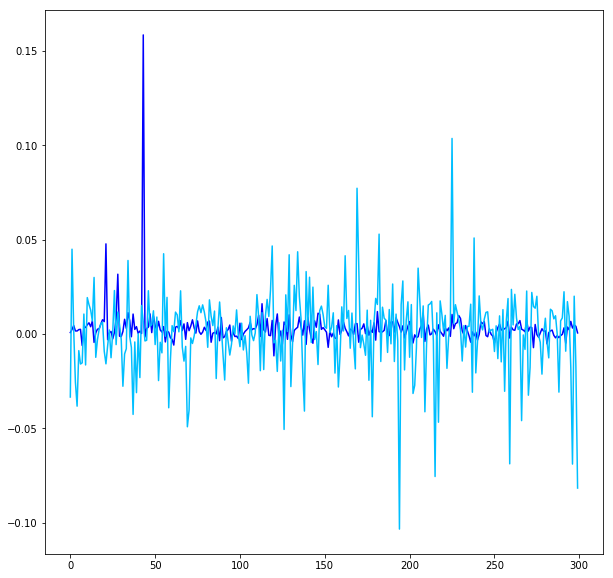

In [21]:
import matplotlib.pyplot as plt

K.clear_session()
net_generator = net_gen.next()
modelconfig=next(net_generator,None)
modelname,model = modelconfig
model.load_weights('log/'+modelname+'_weights.h5')

x_eval = x_test
y_eval = y_test

y_pred = model.predict(x_eval)

plt.figure(figsize=(10,10))
# plt.scatter(y_pred.reshape(-1), y_eval.reshape(-1) )
plt.plot(range(y_pred.shape[0]),y_pred[:,0],color='blue')
plt.plot(range(y_eval.shape[0]),y_eval[:,0],color='deepskyblue')


print('fraction of test cases with positive price movement = {}'.format(len(np.where(y_eval>0)[0])/len(y_eval)))
print('predicted price movement direction accuracy = {}'.format(len(np.where(np.multiply(y_eval,y_pred)>0)[0])/len(y_eval)))

## Conclusion
* The model could not predict the price movement at all.